In [3]:
import sys, os, itertools, numpy as np
sys.path.insert(0, os.path.expanduser("~/Documents/UW/Research/Development"))

def reload():
    from McUtils.Jupyter import ModuleReloader
    if 'McUtils' in sys.modules:
        ModuleReloader('McUtils').reload()
        ModuleReloader('McUtils.McUtils').reload()

from McUtils.Jupyter import *

AttributeError: module 'McUtils.McUtils' has no attribute 'Parsers'

---
title: JHTML - A Web Framework for Jupyter
date: 2022-04-27
permalink: jhtml-a-web-framework-for-jupyter
tags: python jupyter
---

_**Try this live on Binder**_ [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Binder-McUtils/Binder-McUtils/master?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252Fb3m2a1%252Fb3m2a1.github.io%26urlpath%3Dlab%252Ftree%252Fb3m2a1.github.io%252F_posts%252F2022-04-27-JHTML%2BA%2BWeb%2BFramework%2Bfor%2BJupyter.ipynb%26branch%3Dmaster)

Today we're going to be to talking about a package I've been working on intermittently for the past month, which I've been calling `JHTML`.
If I wanted to really sell it, I'd say it's a web framework for Jupyter.
But really at its heart, it just supplies the access to the DOM that one might expect to have, given that Jupyter runs inside the browser.
My initial use case for this was to be able to make little applications that people could use to explore the results of my research.
For instance, I wanted to be able to make something that looked like this

In [122]:
reload(); from McUtils.Jupyter import *
App(
    header=[
        dict(body='Analyzer', cls='navbar-brand', font_weight='bold'),
        Dropdown('File', ('asd',), toggle_attrs=dict(cls=['btn', 'text-light', 'btn-none']))
    ],
    body=JHTML.Div('Spectrum Viewer', height='200px', cls='d-flex justify-content-center align-items-center'),
    sidebar=['Analysis1', 'Analysis2', 'Analysis3', (
        ('Subanalyses', ({'body':'A1', 'event_handlers':{'click':print}}, 'A2')),
        ('Subanalyses', ('A3', 'A4')),
        
    )],
    footer=['some kind of footer text'],
    max_width='800px'å
)

HTMLElement(div, (HTMLElement(div, (HTMLElement(div, (HTMLElement(nav, (HTMLElement(div, (HTMLElement(div, (HT…

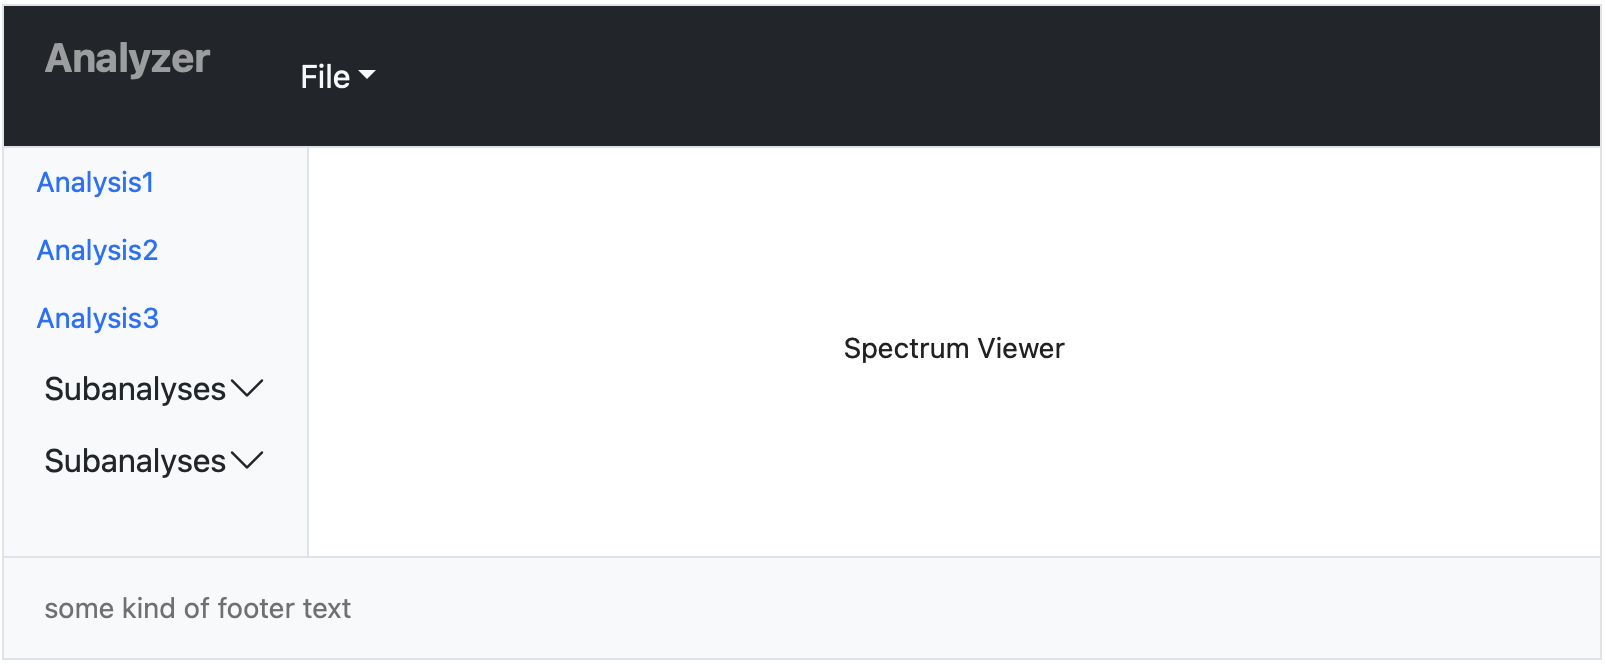

But doing this with the standard [`ipywidgets`](https://ipywidgets.readthedocs.io/en/latest/) package was a pain. 
I had to roll my own CSS and the buttons were clunky and I just really wanted to be able to do what I was used to with [Bootstrap](https://getbootstrap.com/).
The interfaces from Bootstrap are easy and attractive and perfect for getting little prototypes up and running, but things just didn't behave right.

My initial workaround to this was to roll my own HTML generation library and try to use the base `HTML` widget from `ipywidgets`, but that started to break down quickly. I didn't have DOM events, so I couldn't really call into callbacks and the `ipywidgets` input form elements were too clunky and obtrusive for my purposes and it was _still_ too hard to build the quick interfaces I wanted.

At some point in this process, I realized the only thing left to do was to build my own custom widget that would provide the control I needed. 
The earliest incarnation of this thought is [here](https://github.com/jupyter-widgets/ipywidgets/issues/3433).
Building out the custom widget was a huge pain in the neck, but once I had it working things really took off.
Now I can make that interface.
Or I can take an example from Bootstrap and just modify it to add in my features.
Or I can add my own higher-level layers of abstraction to make it nicer to build out content.
And that is what I'd like to demo today.

### Introducing JHTML

The JHTML approach to Jupyter interfaces has two prongs to it. First off, there's the old HTML generation library. 
This has a core `XMLElement` component from which all of the other HTML content types inherit. It allows us to do little things like this

In [129]:
JHTML.Text(
    'Pluto', 
    JHTML.Del('is'), 
    JHTML.Ins('isn’t', 'a planet.')
)

and I've added some helpers to make writing this kind of content nicer like the `JHTML` context manager that exposes all of the JHTML tags as proper names

In [119]:
with JHTML():
    Text('Pluto', Del('is'), Ins('isn’t', 'a planet.')).display()

or a parser that allows us to grab content from the web and use it directly

In [120]:
JHTML.parse("""<p>Pluto<del>is</del> <ins>isn’t</ins> a planet.</p>""")

This part of the library is straightforward and doesn't require any custom widget work, but it's really quite powerful. 
The other part builds off of the [`ActiveHTMLWidget`](https://github.com/b3m2a1/ActiveHTMLWidget) component I wrote to create a tunnel between python and the Jupyter front end.
On top of this I wrote an `ActiveHTMLWrapper` that exposes an interface that behaves as much like the basic `XMLElement` from before.
The only real difference is that this one supports in-place modifications and _DOM events_.
To declare a wrapper, we can either supply the constructor with `event_handlers` or another property that the basic static HTML can't support _or_ we can supply the `dynamic` option.

In [134]:
statement = JHTML.Text(
    'Pluto', 
    JHTML.Del('is'), 
    JHTML.Ins('isn’t', 'a planet.'),
    dynamic=True
)
statement

HTMLElement(div, (HTMLElement(p, (HTMLElement(span, 'Pluto', cls=[], style={}), HTMLElement(del, 'is', cls=[],…

and now we can modify this in place (when running this live, we'd see the original statement change too)

In [133]:
statement['color']='red'
statement

HTMLElement(div, (HTMLElement(p, (HTMLElement(span, 'Pluto', cls=[], style={}), HTMLElement(del, 'is', cls=[],…

### Playing with Bootstrap

As part of building my custom widget, I also included the ability to use Bootstrap CSS and JS.
I figured given that this is largely a _protoyping_ library this would be particularly useful.
This means we can grab CSS directly from the [Bootstrap website](https://getbootstrap.com/docs/5.0/forms/layout/) and do a `parse`/`dump` loop to get nice form layouts. 
Here's a rather complicated example of a user address/signup form scraped almost directly from the web but with `track_value` added to each of the fields so we can edit them and get their `value` attributes out.

In [157]:
with JHTML() as j:
    firstName=Input(type='text', cls='form-control', id='validationTooltip01', value='Mark', required='true', track_value=True)
    lastName=Input(type='text', cls='form-control', id='validationTooltip02', value='Otto',required='true', track_value=True)
    username=Input(type='text', cls='form-control', id='validationTooltipUsername', aria_describedby='validationTooltipUsernamePrepend', required='true', track_value=True)
    cityName = Input(type='text', cls='form-control', id='validationTooltip03', required='true', track_value=True)
    stateName = Select(
          Option('Choose...', selected='true', disabled='true', value=''),
          Option('...'),
          cls='form-select',
          id='validationTooltip04',
          required='true', 
          track_value=True
          )
    zipcode = Input(type='text',cls='form-control', id='validationTooltip05', value='12321', required='true', track_value=True)
    form = Form(
      Div(
        Label('First name', use_for='validationTooltip01', cls='form-label'),
        firstName,
        Div('Looks good!', cls='valid-tooltip'),
        cls='col-md-4 position-relative'
        ),
      Div(
        Label('Last name', use_for='validationTooltip02', cls='form-label'),
        lastName,
        Div('Looks good!', cls='valid-tooltip'),
        cls='col-md-4 position-relative'
        ),
      Div(
        Label('Username', use_for='validationTooltipUsername', cls='form-label'),
        Div(
          Span('@', cls='input-group-text', id='validationTooltipUsernamePrepend'),
          username,
          Div('Please choose a unique and valid username.', cls='invalid-tooltip'),
          cls='input-group has-validation'
          ),
        cls='col-md-4 position-relative'
        ),
      Div(
        Label('City', use_for='validationTooltip03', cls='form-label'),
        cityName,
        Div('Please provide a valid city.', cls='invalid-tooltip'),
        cls='col-md-6 position-relative'
        ),
      Div(
        Label('State', use_for='validationTooltip04', cls='form-label'),
        stateName,
        Div('Please select a valid state.', cls='invalid-tooltip'),
        cls='col-md-3 position-relative'
        ),
      Div(
        Label('Zip', use_for='validationTooltip05', cls='form-label'),
        zipcode,
        Div('Please provide a valid zip.', cls='invalid-tooltip'),
        cls='col-md-3 position-relative'
        ),
      Div(Button('Submit form', type='button', cls='btn btn-primary', event_handlers={'click':lambda *e:print(firstName.value, lastName.value, zipcode.value)}), cls='col-12'),
      Hr(),
      j.out,
      cls='row g-3 needs-validation',
      novalidate='true'
      )
form

HTMLElement(div, (HTMLElement(form, (HTMLElement(div, (HTMLElement(label, 'First name', cls=['form-label'], st…

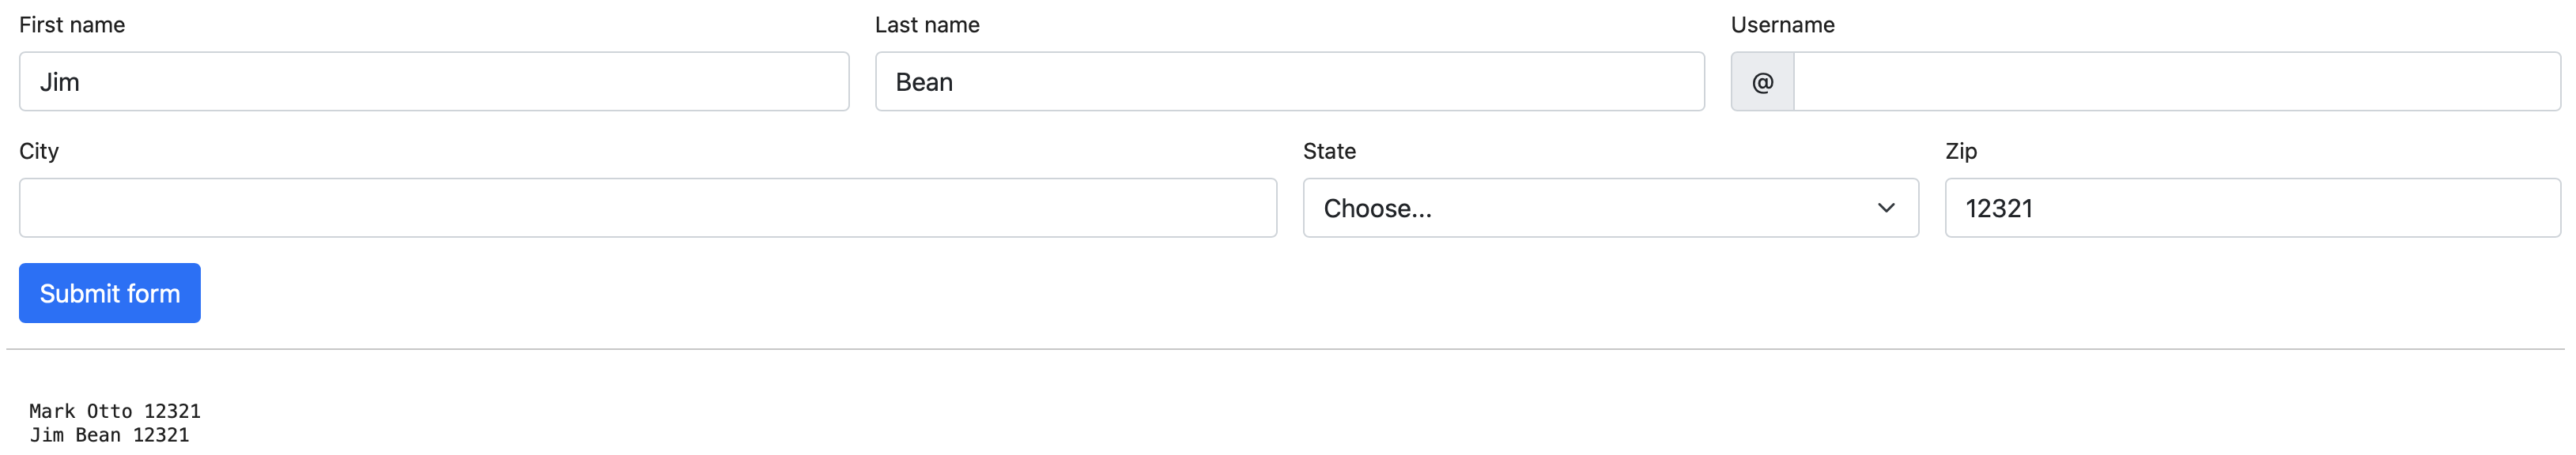

This also demonstrates another useful feature of the `JHTML` context manager: it provides a `DefaultOutputArea` (bound in this case to `j.out`) which can capture all output and errors from callbacks. This makes it much easier to debug interfaces as we set them up.

### Going Higher-Level: Interface Components and Variables

This widget-based approach is very powerful and very flexible.
It provides everything I wanted when I set out to make this framework.
But as I was designing my _own_ forms I realized I could do even better by adding a layer on the python side to manage variable updates
and to help with constructing forms in common cases.
Taking aother page out of the Bootstrap book I called the construction helpers _components_ and I tried to provide most of the basic ones.
They act essentially like higher-level HTML elements, supporting classes, styles, and the rest of it.

In [174]:
Card('Header', 'body', 'footer')

HTMLElement(div, (HTMLElement(div, (HTMLElement(div, (HTMLElement(span, 'H', cls=[], style={}), HTMLElement(sp…

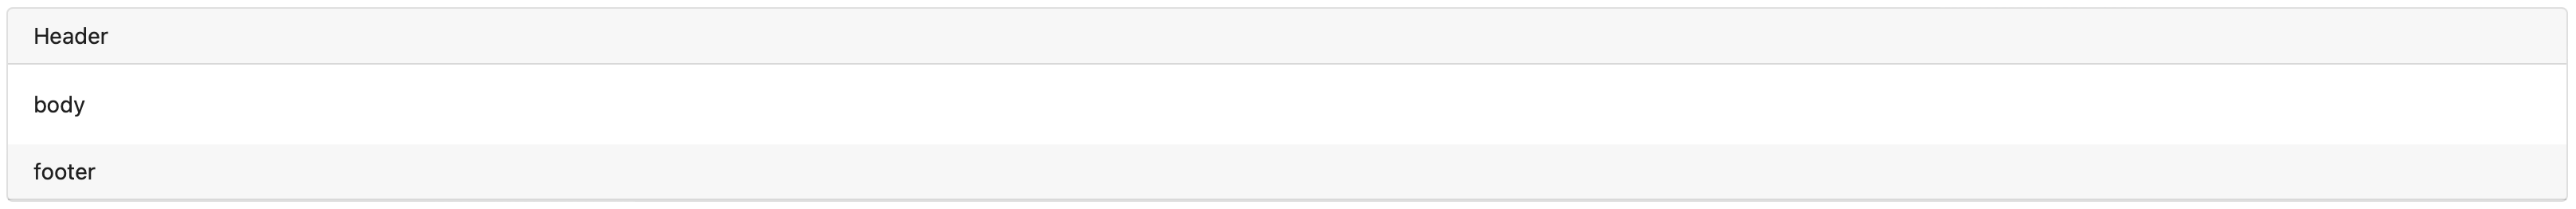

In [175]:
Grid([
    [Grid.Item(Navbar(['Main', 'sub', 'sub'], cls='navbar-dark bg-dark'), col_span=2)],
    [Sidebar(['Link 1', 'Link 2', 'Link 3'], cls='bg-light h-100'), Card('Header', 'body', 'footer')]
    ],
    column_width=['auto', '1fr'],
    row_height=['auto', '1fr']
)

HTMLElement(div, (HTMLElement(div, (HTMLElement(div, (HTMLElement(nav, (HTMLElement(div, (HTMLElement(div, (HT…

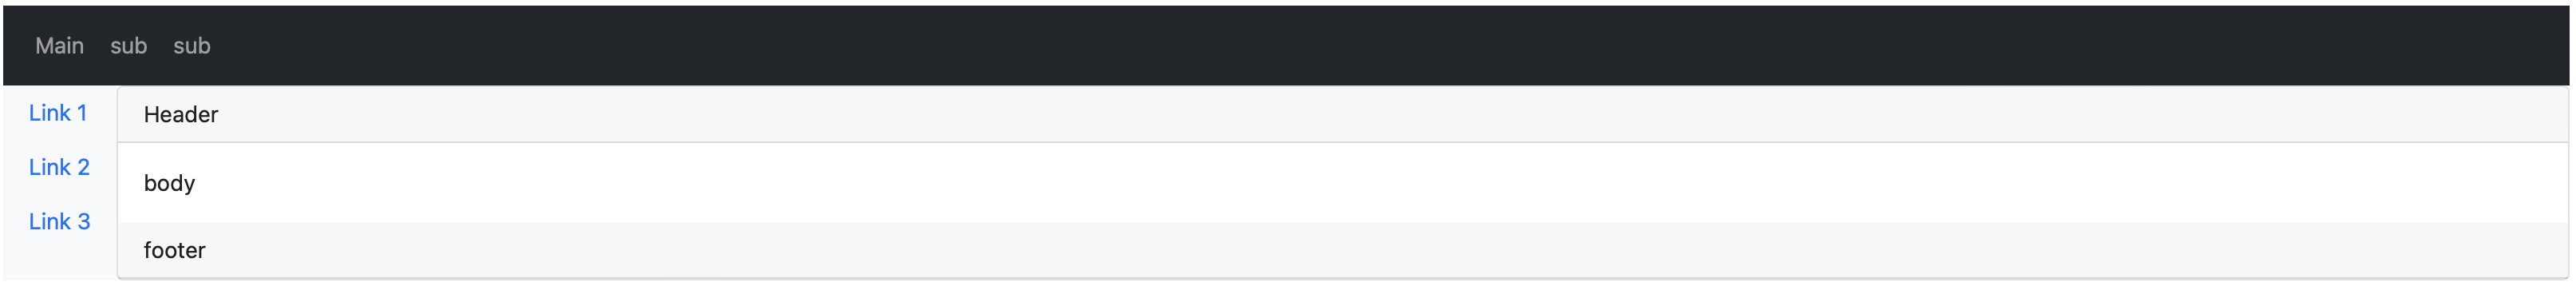

In [176]:
Tabs({'Tab1':'body 1', 'Tab2':'body2'})

HTMLElement(div, (HTMLElement(div, (HTMLElement(ul, (HTMLElement(li, '<button id="tabs-22027-Tab1-tab" data-bs…

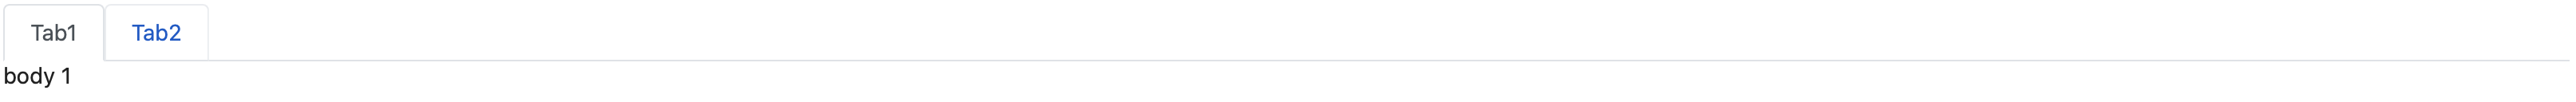

I also made it easy to define your own components. E.g. here's a `Pagination` component based off of Bootstrap pagination

In [181]:
Pagination(["«", "1", "2", "3", "»"])

HTMLElement(div, (HTMLElement(nav, (HTMLElement(ul, (HTMLElement(li, '<a class="page-link">&#171;</a>', cls=['…

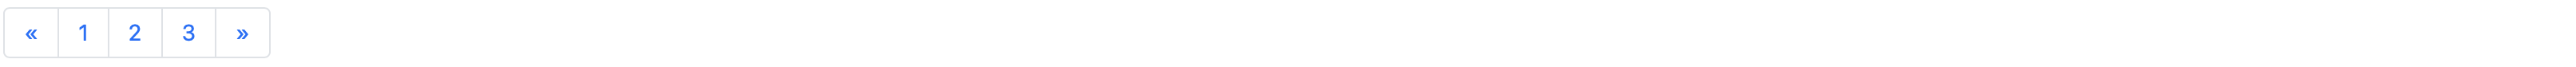

But the entirety of the code to implement that is given by

In [ ]:
class Pagination(MenuComponent):
    wrapper = JHTML.Nav
    subwrappers = [JHTML.Ul]
    subwrapper_classes = [['pagination']]
    item = JHTML.Compound(
        JHTML.Styled(JHTML.Li, cls='page-item'),
        JHTML.Anchor
    )
    item_classes = ['page-link']

Which was itself a direct translation of the HTML fragment

```html
<nav aria-label="Page navigation example">
  <ul class="pagination">
    <li class="page-item">
      <a class="page-link" href="#" aria-label="Previous">
        <span aria-hidden="true">&laquo;</span>
      </a>
    </li>
    <li class="page-item"><a class="page-link" href="#">1</a></li>
    <li class="page-item"><a class="page-link" href="#">2</a></li>
    <li class="page-item"><a class="page-link" href="#">3</a></li>
    <li class="page-item">
      <a class="page-link" href="#" aria-label="Next">
        <span aria-hidden="true">&raquo;</span>
      </a>
    </li>
  </ul>
</nav>
```

As a more involved example, we could also imagine adding a `Carousel`, which has HTML given by

```html
<div id="carouselExampleControls" class="carousel slide" data-bs-ride="carousel">
  <div class="carousel-inner">
    <div class="carousel-item active">
      <img src="..." class="d-block w-100" alt="...">
    </div>
    <div class="carousel-item">
      <img src="..." class="d-block w-100" alt="...">
    </div>
    <div class="carousel-item">
      <img src="..." class="d-block w-100" alt="...">
    </div>
  </div>
  <button class="carousel-control-prev" type="button" data-bs-target="#carouselExampleControls" data-bs-slide="prev">
    <span class="carousel-control-prev-icon" aria-hidden="true"></span>
    <span class="visually-hidden">Previous</span>
  </button>
  <button class="carousel-control-next" type="button" data-bs-target="#carouselExampleControls" data-bs-slide="next">
    <span class="carousel-control-next-icon" aria-hidden="true"></span>
    <span class="visually-hidden">Next</span>
  </button>
</div>
```

We mimic that by providing the component

In [ ]:
class Carousel(MenuComponent):
    wrapper = JHTML.Div
    wrapper_classes = ['carousel']
    subwrappers = [JHTML.Div]
    subwrapper_classes = ['carousel-inner']
    item = JHTML.Div
    item_classes = ['carousel-item', 'bg-secondary', 'text-light']
    def __init__(self, items, include_controls=True, data_bs_ride='carousel', **attrs):
        self.include_controls = include_controls
        self._active_made = False
        self.base_name = 'carousel-' + short_uuid()
        super().__init__(items, id=self.base_name, data_bs_ride=data_bs_ride, **attrs)
    def create_item(self, item, cls=None, data_bs_interval="10000000000", **kw):
        if not self._active_made:
            cls = JHTML.manage_cls(cls) + ['active']
            self._active_made = True
        return super().create_item(item, cls=cls, data_bs_interval=data_bs_interval, **kw)
    def wrap_items(self, items):
        base = super().wrap_items(items)
        if self.include_controls:
            base.append(
                JHTML.Button(
                    JHTML.Span(cls='carousel-control-prev-icon'),
                    cls='carousel-control-prev', data_bs_target='#'+self.base_name, data_bs_slide='prev'
                )
            )

            base.append(
                JHTML.Button(
                    JHTML.Span(cls='carousel-control-next-icon'),
                    cls='carousel-control-next', data_bs_target='#'+self.base_name, data_bs_slide='next'
                )
            )
        return base

which looks like the following when used

In [214]:
Carousel(
    [
        JHTML.Div('1', cls=['d-flex', 'justify-content-center', 'align-items-center'], min_height='100px', min_width='100px'), 
        JHTML.Div('2', cls=['d-flex', 'justify-content-center', 'align-items-center'], min_height='100px', min_width='100px'), 
        JHTML.Div('3', cls=['d-flex', 'justify-content-center', 'align-items-center'], min_height='100px', min_width='100px') 
    ]
)

HTMLElement(div, (HTMLElement(div, (HTMLElement(button, '<span class="carousel-control-prev-icon"></span>', cl…

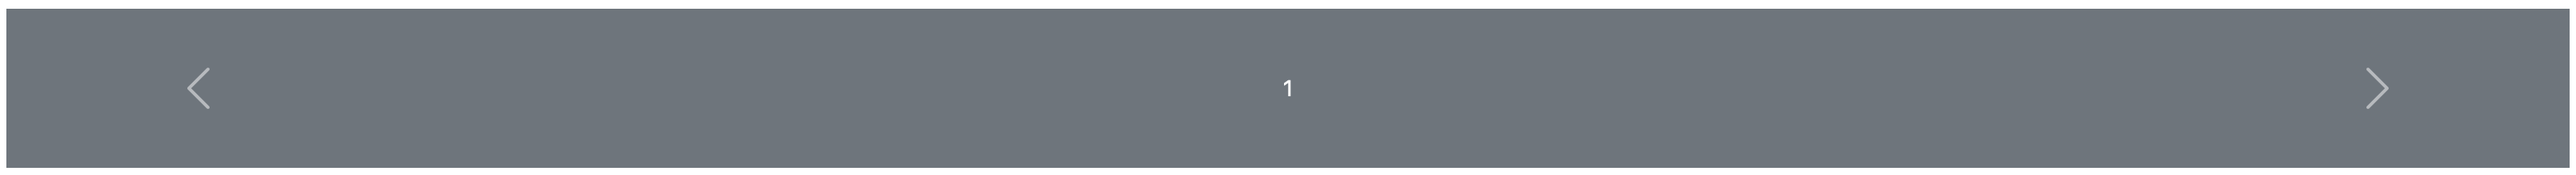

There is also nothing stopping someone from loading their own framework of choice, e.g. [Stimulus](https://stimulus.hotwired.dev/handbook/installing#using-without-a-build-system), another nice quick-to-use Javascript library. You do not even need to work with Javascript at all. Complex interface manipulations can be done entirely on the python side through JHTML events (although it will be faster to work entirely on the JS side when possible). 

Here's a way we can a `Grid` system that will can hide or show its elements based on a set of clickable buttons, sort of like a grid of spoilers

In [264]:
class SpoilerGrid(Grid):
    def wrap_item(self, item, attrs):
        if 'cls' in attrs:
            cls = JHTML.manage_cls(cls) + ['d-none']
        else:
            cls = ['opacity-25', 'bg-dark']
        attrs['cls'] = cls
        attrs['dynamic'] = True
        return super().wrap_item(item, attrs)
    def toggle_item(self, i):
        item = self.elements[i].to_widget()
        if 'opacity-25' in item.class_list:
            item.remove_class('opacity-25', 'bg-dark')
        else:
            item.add_class('opacity-25', 'bg-dark')            
    def to_jhtml(self):
        base = super().to_jhtml()
        buttons = [
            JHTML.Bootstrap.Button(btn_idx+1, event_handlers={'click':lambda *e,i=btn_idx:self.toggle_item(i)}) 
            for btn_idx in range(len(self.elements))
        ]
        return JHTML.Div(JHTML.Div(*buttons, cls='btn-group'), base)

Here I just made the content translucent and added a dark background to make it appear as if it were masked, but obviously more sophisticated methods could be used to get this effect. Here's what it looks like in action

In [371]:
SpoilerGrid([[1, 2], [3, 4]], max_width='600px')

HTMLElement(div, (HTMLElement(div, (HTMLElement(div, (HTMLElement(button, (HTMLElement(span, '1', cls=[], styl…

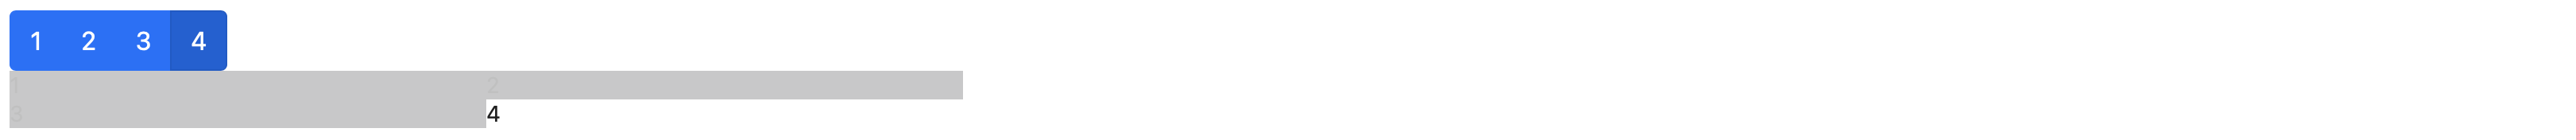

The interface is nothing to write home about, but it was quick and easy to implement and definitely supports my desire to be able to get prototypes done fast.

You'll also notice that instead of overloading the `create_item` and `wrap_items` methods I had to overload `to_html` and `wrap_item`.
This is really just a manifestation of the library being young (i.e. I got it to a working state less than 2 weeks ago) and the interfaces aren't all figured out yet.
It has been a lot of fun to see the pieces come together though and hopefully the broader community will be able to provide input and make good use of the framework.

### Variables, Controls, and Apps

The core `JHTML` framework has been a lot of fun to play with. 
It has been nice to see the components come together to make a python-friendly interfaces.
But one big missing element we haven't discussed yet is variables and callbacks.
Being required to query the `value` property of all of our interface elements (as we did before) is hard to scale.
And as I tried to make more interesting forms I realized I needed to add a system for tracking variables throughout an interface, 
so I added a `Var` constructor that very simply tracks a `value` and allows for callbacks when the value is updated.
Usually, this ends up being used inside a `Control` of some form, and I've provided all the standard ones

In [364]:
reload(); from McUtils.Jupyter import *

Grid([
    [
        Slider('val'),
        StringField('str', placeholder='a string'),
        Selector('opt', ['a', 'b', 'c']),
    ],
    [
        Checkbox('flag', value=True),
        RadioButton('flag'),
        Switch('flag')
    ],
    [
        Selector('opts', ['a', 'b', 'c'], value=['c'], multiple=True),
        TextArea('txt', value='lorem ipsum etc')
    ]
]
)

HTMLElement(div, (HTMLElement(div, (HTMLElement(div, (HTMLElement(input, '', cls=['form-range'], style={}),), …

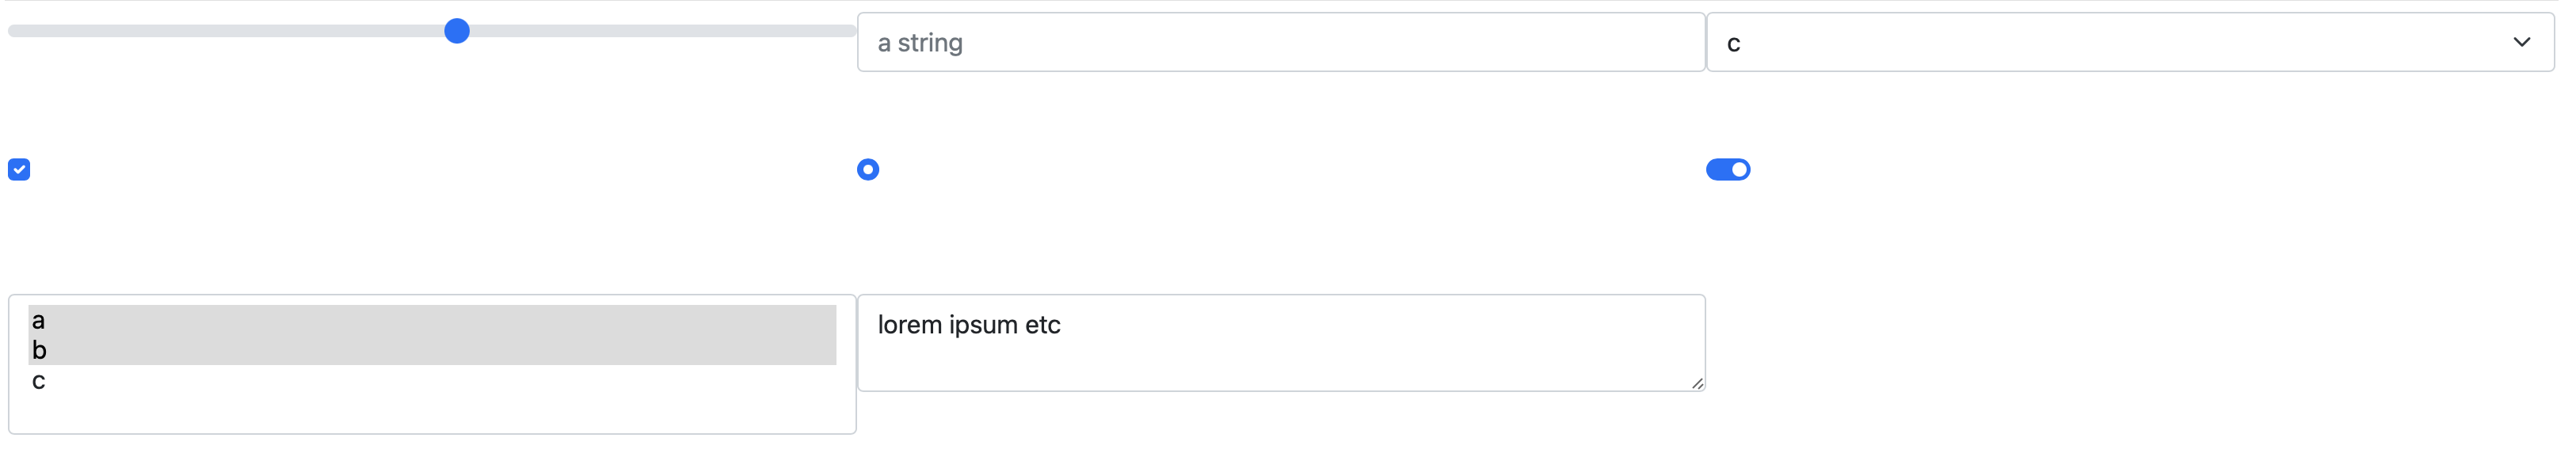

But with these I realized I also needed (at least) a few others. First off, I definitely needed one to track the value of a variable

In [366]:
Grid([[VariableDisplay('opts'), VariableDisplay('val')]])

HTMLElement(div, (HTMLElement(div, (HTMLElement(div, (HTMLElement(div, (Output(),), cls=[], style={}),), cls=[…

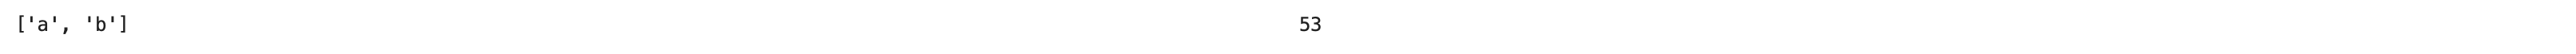

And similarly, I needed one to update a function everytime a variable is updated to provide interactivity like `interact`. Here we just provide the `Grid` from before. This is less efficient than updating the variable display (since the whole function needs to be updated), but both are more than good enough for most things.

In [369]:
FunctionDisplay(lambda *e,opts=None,val=None,**kw: Grid([[opts, val]]), ['opts', 'val'])

HTMLElement(div, (HTMLElement(div, (Output(),), cls=[], style={}),), cls=['jhtml'], style={})

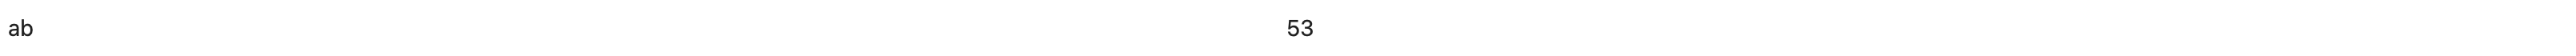

### Custom App Layouts

The flexibility afforded by all of the components outlined above should cover the vast majority of cases, but it is also true that there are some layouts that are so common it makes sense to create bespoke format classes.
Currently, the only one I really have I've been calling `App` and it is what was used to construct the layout I wanted to be able to build when I set out on this project.
The basic layout looks like this

In [375]:
App(
    header=["header"],
    body=["body"],
    toolbar=["toolbar"],
    sidebar=["sidebar"],
    footer=["footer"]
)

HTMLElement(div, (HTMLElement(div, (HTMLElement(div, (HTMLElement(nav, (HTMLElement(div, (HTMLElement(div, '<a…

The lists are there so that rather than needing to provide a fully constructed JHTML interface, we can content as a `dict`, which also allows us to internally supply wrappers for callbacks and that sort of thing. For instance, here's a more fully fleshed-out example

In [ ]:
App(
    header=["header"],
    body=["body"],
    toolbar=["toolbar"],
    sidebar=["sidebar"],
    footer=["footer"]
)

# Export

In [1]:
from McUtils.Jupyter import ModuleReloader
if 'McUtils' in sys.modules:
    ModuleReloader('McUtils').reload()
    ModuleReloader('McUtils.McUtils').reload()
from McUtils.Jupyter import NotebookExporter

NotebookExporter('2022-04-27-JHTML A Web Framework for Jupyter',
                img_dir=os.path.join(os.path.dirname(os.getcwd()), 'img'),
                img_prefix='{{site.url}}/img/'
                ).export();

ModuleNotFoundError: No module named 'McUtils'